In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import os.path as op
import numpy as np
import nibabel as nb

from pyhrf.ndarray import xndarray
from pyhrf.plot import autocrop

archives = op.join('/media', 'aina', 'MISTIS', 'Data')
folder = op.join(archives, 'tests_HEROES')
if not op.exists(folder): os.mkdir(folder)
data_fn = op.join(archives, 'HEROES_preprocessed', 'AC150013', 'Preprocessed',
                  'wravismot1_BOLDepi2_ac150013_20150121_acq1_11.nii')
paradigm_fn = op.join(archives, 'HEROES_DB', 'paradigm_data', 'paradigm_bilateral_v1_no_final_rest.csv')

### The experimental paradigm

In [4]:
from pyhrf.paradigm import Paradigm

paradigm = Paradigm.from_csv(paradigm_fn)
conditions = paradigm.get_stimulus_names()
onsets = paradigm.get_joined_onsets()
durations = paradigm.get_joined_durations()
print conditions
print onsets
print durations

['checkerboard_motor_d5000_left', 'checkerboard_motor_d2500_right', 'checkerboard_motor_d2500_left', 'checkerboard_motor_d5000_right']
OrderedDict([('checkerboard_motor_d5000_left', array([  80.,  155.,  205.,  330.])), ('checkerboard_motor_d2500_right', array([ 105.,  180.,  280.,  380.])), ('checkerboard_motor_d2500_left', array([   5.,  130.,  255.,  355.])), ('checkerboard_motor_d5000_right', array([  30.,   55.,  230.,  305.]))])
OrderedDict([('checkerboard_motor_d5000_left', array([ 15.,  15.,  15.,  15.])), ('checkerboard_motor_d2500_right', array([ 15.,  15.,  15.,  15.])), ('checkerboard_motor_d2500_left', array([ 15.,  15.,  15.,  15.])), ('checkerboard_motor_d5000_right', array([ 15.,  15.,  15.,  15.]))])


In [5]:
from nistats import hemodynamic_models
from scipy.signal import convolve

max_time = 400
TR, oversampling, time_length = 2.5, 1., 25.
time_grid = np.mgrid[0:max_time:1]
time_line = np.zeros((len(time_grid)))

for cond in onsets:
    for ions, ons in enumerate(onsets[cond]):
        time_line[ons:ons+durations[cond][ions]] = 1.
#print time_line


hrf = hemodynamic_models.glover_hrf(tr=TR, oversampling=oversampling, time_length=time_length)
hrf /= np.linalg.norm(hrf)
continuous_regressors = convolve(time_line, hrf, mode='full')

[0, 100, -1, 2]

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


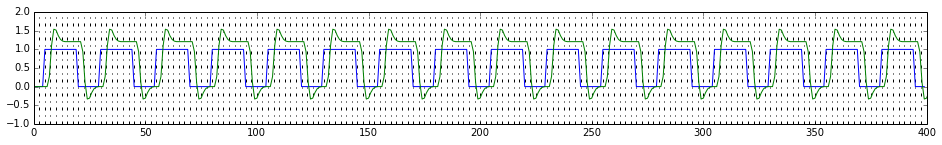

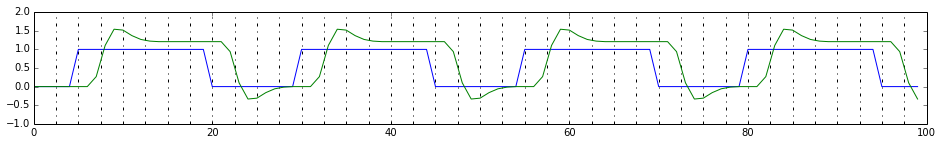

In [6]:
plt.figure(figsize=(16, 2))
plt.plot(time_line)
plt.plot(continuous_regressors)
plt.vlines(np.arange(0, time_grid.max(), TR), -1, 12, linestyle='-.')
plt.axis([0, max_time, -1, 2])

plt.figure(figsize=(16, 2))
plt.plot(time_line[:100])
plt.plot(continuous_regressors[:100])
plt.vlines(np.arange(0, 100, TR), -1, 12, linestyle='-.')
plt.axis([0, 100, -1, 2])

### The design matrix

    run                            name  onset  duration  modulation
0     0   checkerboard_motor_d5000_left     80        15           1
1     0   checkerboard_motor_d5000_left    155        15           1
2     0   checkerboard_motor_d5000_left    205        15           1
3     0   checkerboard_motor_d5000_left    330        15           1
4     0  checkerboard_motor_d2500_right    105        15           1
5     0  checkerboard_motor_d2500_right    180        15           1
6     0  checkerboard_motor_d2500_right    280        15           1
7     0  checkerboard_motor_d2500_right    380        15           1
8     0   checkerboard_motor_d2500_left      5        15           1
9     0   checkerboard_motor_d2500_left    130        15           1
10    0   checkerboard_motor_d2500_left    255        15           1
11    0   checkerboard_motor_d2500_left    355        15           1
12    0  checkerboard_motor_d5000_right     30        15           1
13    0  checkerboard_motor_d5000_

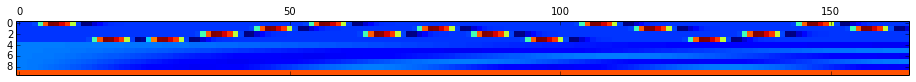

In [14]:
from nistats.glm import FirstLevelGLM
from nistats import experimental_paradigm, design_matrix

# Load data and parameters
t_r = 2.5
niimg = nb.load(data_fn)
bold_data = niimg.get_data()
n_scans = bold_data.shape[3]

# Build design matrix
frametimes = np.arange(0, n_scans * t_r, t_r)
paradigm_fn = op.join(archives, 'HEROES_DB', 'paradigm_data', 'paradigm_bilateral_v1_no_final_rest_notebook.csv')
paradigm = experimental_paradigm.paradigm_from_csv(paradigm_fn)
print paradigm
dm = design_matrix.make_design_matrix(frametimes, paradigm=paradigm)
plt.matshow(dm.T)

### Frequency analysis of the paradigm, compared to AGIR data (GIN)
Comparison of frequency spectrum of both paradigms. We cant detect frequencies in output that we don't have in input

In [8]:
def compute_fft_and_ifft_paradigm(pd1, pd2, hrf, use='numpy'):
    # Compute FFT
    if use=='numpy':
        from numpy.fft import fft, ifft
    else:
        from scipy.fftpack import fft, ifft
    fp1, fp2, fhrf = fft(pd1), fft(pd2), fft(hrf)
    # Cut off frequency spectra depending on the TR
    fp1[np.abs(freqs)>(1./TR1)], fp2[np.abs(freqs)>(1./TR2)] = 0, 0 
    # normalized absolute value of FT
    afp1, afp2, afhrf = np.abs(fp1)/np.max(np.abs(fp1)),np.abs(fp2)/np.max(np.abs(fp2)),np.abs(fhrf)/np.max(np.abs(fhrf)) 
    # calculate FT of HRFs sampled at frequency components present in the respective paradigms
    s1_fhrf, s2_fhrf = fhrf.copy(), fhrf.copy()
    s1_fhrf[np.abs(fp1) < eps], s2_fhrf[np.abs(fp2) < eps] = 0., 0.
    s1_hrf, s2_hrf = ifft(s1_fhrf), ifft(s2_fhrf)
    s1_hrf, s2_hrf = s1_hrf - s1_hrf[0], s2_hrf - s2_hrf[0]
    s1_hrf, s2_hrf = s1_hrf[0:nhrf+1] / np.max(np.abs(s1_hrf)), s2_hrf[0:nhrf+1] / np.max(np.abs(s2_hrf))
    return afp1, afp2, afhrf, s1_hrf, s2_hrf

differences scipy and numpy FFT functions: 
FFT paradigm 1: 2.19831685917e-14 , FFT paradigm 2: 3.02032937244e-15 , FFT HRF: 6.02908175451e-14
iFFT paradigm 1: 4.12138682355 , iFFT paradigm 2: 9.511779705 , iFFT HRF: 4.12138682355


/home/aina/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


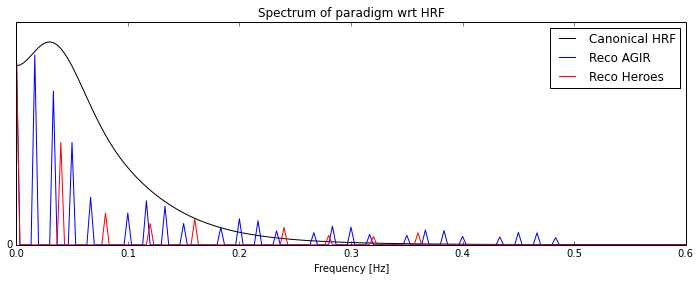

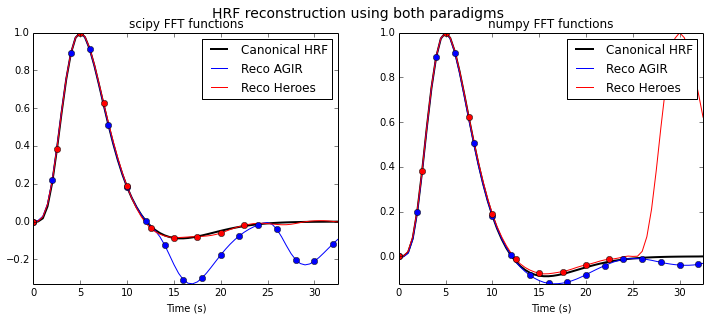

In [9]:
# Perform calculations in parallel:  - Index "1": AGIR data, - Index "2": Heroes data
eps = np.spacing(1)
time_length, dt, TR1, TR2 = 32., 0.5, 2, 2.5      # in seconds
p1 = np.round(np.array([0, 6, 24]) * TR1 / dt)    # Paradigm 1 (off-on-off periods), units of sample times
p2 = np.round(np.array([0, 6, 4]) * TR2 / dt)     # Paradigm 2 (off-on-off periods), units of sample times
n1, n2 = np.sum(p1), np.sum(p2)                   # duration of one stimulation period in units of sample times
ntot = n1 * n2 / np.core._internal._gcd(n1, n2)   # Total duration as LCM of individual stimulation periods
Ttot = ntot * dt                                  # Total duration in seconds
# Construct paradigms of 1's and 0's with the given sample time and a common total duration
pd1 = np.tile(np.concatenate((np.zeros((1,p1[0])),np.ones((1,p1[1])),np.zeros((1,p1[2]))), axis=1), (1,ntot/n1)).squeeze()
pd2 = np.tile(np.concatenate((np.zeros((1,p2[0])),np.ones((1,p2[1])),np.zeros((1,p2[2]))), axis=1), (1,ntot/n2)).squeeze()
# Construct HRF
from nipype.algorithms.modelgen import spm_hrf
hrf = spm_hrf(dt)
nhrf = len(hrf)
hrf = np.append(hrf, np.zeros((ntot - nhrf,)))  # Zero filling to the same length as paradigm
# FFT / iFFT
freqs = (1 / Ttot) * np.arange(0, ntot)
fNyq  = 1 / (2 * dt)
freqs[freqs > fNyq] = freqs[freqs > fNyq] - 2 * fNyq
i_hrf = np.arange(0, nhrf + 1)
i_s1, i_s2 = np.arange(0, min(n1, nhrf+1), TR1/dt).astype(int), np.arange(0, min(n2, nhrf+1), TR2/dt).astype(int)
t_hrf, t_s1, t_s2 = dt * i_hrf, dt * i_s1, dt * i_s2
sc_afp1, sc_afp2, sc_afhrf, sc_s1_hrf, sc_s2_hrf = compute_fft_and_ifft_paradigm(pd1, pd2, hrf, use='scipy')
np_afp1, np_afp2, np_afhrf, np_s1_hrf, np_s2_hrf = compute_fft_and_ifft_paradigm(pd1, pd2, hrf, use='numpy')

plt.figure(figsize=(12, 4)) 
plt.plot(freqs[freqs >= 0], np_afhrf[freqs >= 0],'k', label='Canonical HRF')
plt.plot(freqs[freqs >= 0], np_afp1[freqs >= 0],'b', label='Reco AGIR')
plt.plot(freqs[freqs >= 0], np_afp2[freqs >= 0],'r', label='Reco Heroes')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.axis([0, 0.6, 0, 1.1])
plt.yticks(np.arange(0, 1. / min(TR1,TR2)))
plt.title('Spectrum of paradigm wrt HRF')

f, ax = plt.subplots(1, 2, figsize=(12, 4.5))
f.suptitle('HRF reconstruction using both paradigms', fontsize=14)
ax[0].plot(t_hrf, hrf[i_hrf]/np.max(np.abs(hrf)), 'k', linewidth=2, label='Canonical HRF')
ax[0].plot(t_hrf, sc_s1_hrf[i_hrf], 'b', label='Reco AGIR')
ax[0].plot(t_hrf, sc_s2_hrf[i_hrf], 'r', label='Reco Heroes')
ax[0].legend()
ax[0].plot(t_s1, sc_s1_hrf[i_s1], 'bo')
ax[0].plot(t_s2, sc_s2_hrf[i_s2], 'ro')
ax[0].axis('tight')
ax[0].set_xlabel('Time (s)')
ax[0].set_title('scipy FFT functions')
ax[1].plot(t_hrf, hrf[i_hrf]/np.max(np.abs(hrf)), 'k', linewidth=2, label='Canonical HRF')
ax[1].plot(t_hrf, np_s1_hrf[i_hrf], 'b', label='Reco AGIR')
ax[1].plot(t_hrf, np_s2_hrf[i_hrf], 'r', label='Reco Heroes')
ax[1].legend()
ax[1].plot(t_s1, np_s1_hrf[i_s1], 'bo')
ax[1].plot(t_s2, np_s2_hrf[i_s2], 'ro')
ax[1].axis('tight')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('numpy FFT functions')
print 'differences scipy and numpy FFT functions: '
print 'FFT paradigm 1:', np.abs(sc_afp1 - np_afp1).sum(), ', FFT paradigm 2:', np.abs(sc_afp2 - np_afp2).sum(), \
     ', FFT HRF:', np.abs(sc_afhrf - np_afhrf).sum()
print 'iFFT paradigm 1:', np.abs(sc_s1_hrf - np_s1_hrf).sum(), ', iFFT paradigm 2:', np.abs(sc_s2_hrf - np_s2_hrf).sum(),\
     ', iFFT HRF:', np.abs(sc_s1_hrf - np_s1_hrf).sum()

The FFT results using numpy, scipy and matlab are different!!!

Numpy FFT computes the 1-dimensional n-point discrete Fourier Transform (DFT) with the efficient Fast Fourier Transform (FFT) algorithm [CT].

$$A_k = \sum_{m=0}^{n-1} a_m \exp\left\{-2\pi i{mk \over n}\right\} \qquad k = 0,\ldots,n-1.$$

Scipy FFT returns discrete Fourier transform of real or complex sequence.
I would say it is the same...

### GLM analysis

In [64]:
from nilearn.input_data import NiftiMasker
from nistats import glm

# Construct masker and run GLM
affine = niimgs.get_affine()
mask_img = nb.Nifti1Image(np.ones(bold_data.shape[0:3]), affine=affine)
masker = NiftiMasker(mask_img=mask_img)
#masker = NiftiMasker(mask_strategy='background')
niimgs_masked = masker.fit_transform(niimgs)
glm_results = glm.session_glm(niimgs_masked, dm, noise_model='ols')
labels = glm_results[0]
reg_results = glm_results[1]

In [129]:
norm_resid = (np.linalg.norm(reg_results[0].resid, axis=0)).mean()
sqnorm_resid = (np.linalg.norm(reg_results[0].resid, axis=0)**2).mean()
print 'Residual norm = ', norm_resid
print 'Squared residual norm = ', sqnorm_resid
print
print 'conditions:'
print dm.keys()[0]
print dm.keys()[1]
print dm.keys()[2]
print dm.keys()[3]

Residual norm =  37.6948906123
Squared residual norm =  3040.034703

conditions:
checkerboard_motor_d2500_left
checkerboard_motor_d2500_right
checkerboard_motor_d5000_left
checkerboard_motor_d5000_right


d2500
d5000
d2500_left
d2500_right
d5000_left
d5000_right


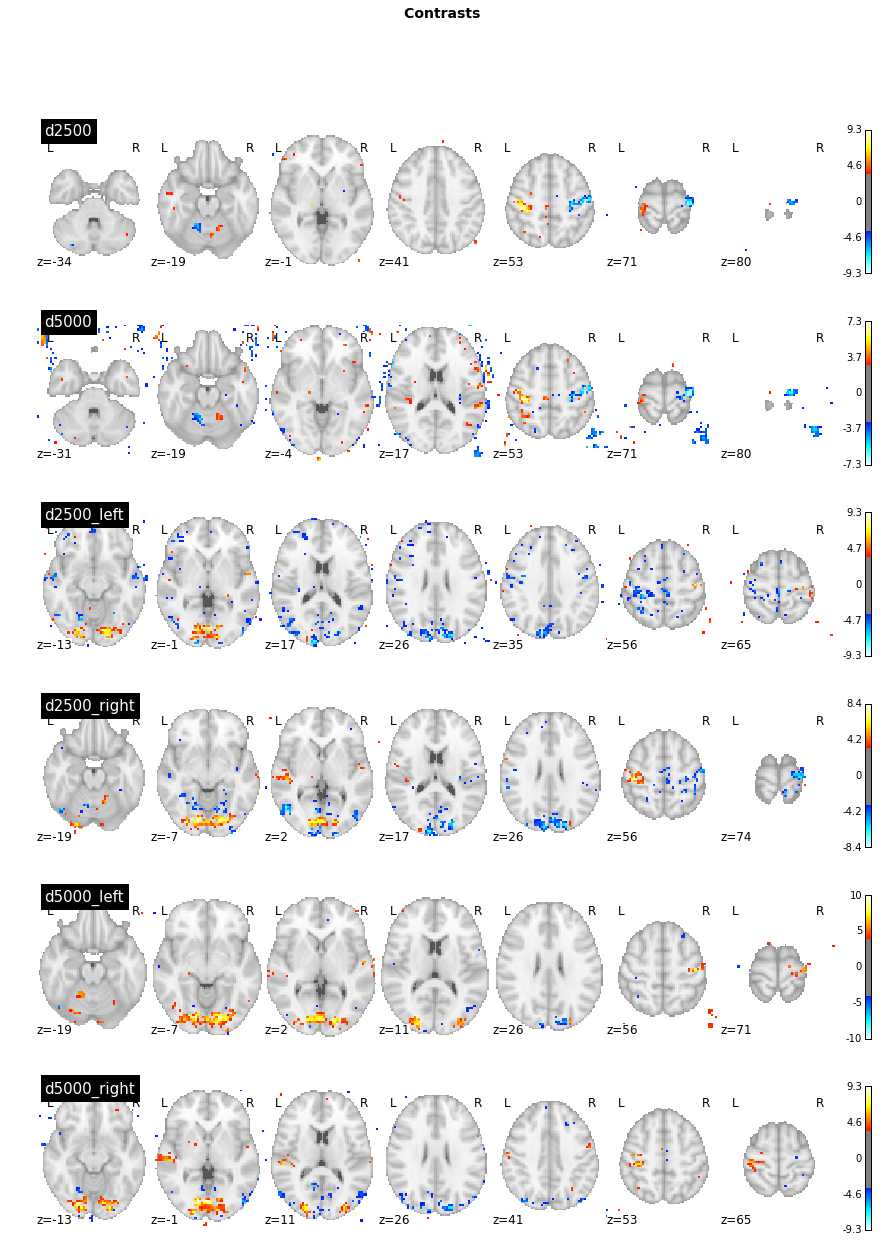

In [126]:
from nilearn.plotting import plot_stat_map, plot_glass_brain
from nipy.labs.viz import plot_map, cm

# Compute contrasts
contrasts = [np.array([-1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
             np.array([ 0, 0,-1, 1, 0, 0, 0, 0, 0, 0]),
             np.array([ 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
             np.array([ 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
             np.array([ 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
             np.array([ 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])]
names = ['d2500', 'd5000', 'd2500_left', 'd2500_right', 'd5000_left', 'd5000_right']

f, ax = plt.subplots(len(contrasts), 1, figsize=(15, 20))
f.suptitle('Contrasts ', fontsize=14, fontweight='bold')
for i in xrange(len(contrasts)):
    print names[i]
    contrast_map = glm.compute_contrast(labels, reg_results, contrasts[i])
    pvalues = contrast_map.p_value()
    pvalues_img = nb.Nifti1Image(np.reshape(pvalues, bold_data.shape[0:3]), affine=affine)
    zscore = contrast_map.z_score()
    zscore_img = nb.Nifti1Image(np.reshape(zscore, bold_data.shape[0:3]), affine=affine)
    
    ind_min_unravel = np.unravel_index(np.argsort(zscore)[-1], bold_data.shape[0:3])    
    (x, y, z) = np.dot(ind_min_unravel, affine[:3, :3]) + affine[:3, 3]
    plot_stat_map(zscore_img, title=names[i], figure=f, #cmap=cm.cold_hot,
                  axes=ax[i], threshold=zscore.max()*0.4, display_mode='z') #, cut_coords=(x, y, z)
    #plot_stat_map(pvalues_img, title=names[i], figure=f, axes=ax[i], cut_coords=(x, y, z), threshold=0.95)
    #plot_glass_brain(pvalues_img, threshold=0.95, title=names[i], figure=f, axes=ax[i], cut_coords=(x, y, z)) 